In [5]:
import pandas as pd  
from tqdm.notebook import tqdm
from moneylinefunctions import *

from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.linear_model import Lasso, RidgeClassifier, LogisticRegression, Ridge
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


tqdm.pandas()

df = pd.read_csv("data/game_logs.csv")
df.drop(columns=['Unnamed: 0'], inplace=True)
df.head()

,SEASON_ID,Player_ID,Game_ID,GAME_DATE,MATCHUP,WL,MIN,FGM,FGA,FG_PCT,...,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,VIDEO_AVAILABLE,PLAYER_NAME,SEASON
0,22023,1629060,22301195,2024-04-14,LAL @ NOP,W,34,5,10,0.500,...,4,2,0,1,1,11,10,1,Rui Hachimura,2023
1,22023,1631104,22301197,2024-04-14,SAS vs. DET,W,30,7,9,0.778,...,5,3,0,1,2,17,24,1,Blake Wesley,2023
2,22023,1630560,22301192,2024-04-14,BKN @ PHI,L,27,5,12,0.417,...,2,0,0,1,0,18,-4,1,Cam Thomas,2023
3,22023,203992,22301188,2024-04-14,ATL @ IND,L,27,6,15,0.400,...,1,2,0,0,2,18,-31,1,Bogdan Bogdanovic,2023
4,22023,1628380,22301197,2024-04-14,SAS vs. DET,W,16,6,11,0.545,...,2,1,0,0,3,17,18,1,Zach Collins,2023


In [6]:
# Query a specific player
specific_player = False 
if specific_player:
    player_df = df.query('PLAYER_NAME == "LeBron James"')
else:
    player_df = df.copy()

# Filter only regular season games
player_df = player_df.loc[player_df['SEASON_ID'].astype(str).str[0:1] == "2"].reset_index(drop = True)

# Create binary home variable 
player_df['Home'] = 0 
player_df.loc[player_df['MATCHUP'].str.contains('@'), 'Home'] = 1

# Make WL a numeric variable
player_df.loc[player_df['WL'] == 'W', 'WL'] = 1
player_df.loc[player_df['WL'] == 'L', 'WL'] = 0
player_df['WL'] = player_df['WL'].astype(int)

# Drop unnecessary columns 
cols_to_drop = [
    'PLAYER_NAME', 'SEASON',
    'VIDEO_AVAILABLE'
]
player_df = player_df.drop(columns=cols_to_drop)
player_df.head()

,SEASON_ID,Player_ID,Game_ID,GAME_DATE,MATCHUP,WL,MIN,FGM,FGA,FG_PCT,...,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,Home
0,22023,1629060,22301195,2024-04-14,LAL @ NOP,1,34,5,10,0.500,...,6,7,4,2,0,1,1,11,10,1
1,22023,1631104,22301197,2024-04-14,SAS vs. DET,1,30,7,9,0.778,...,6,7,5,3,0,1,2,17,24,0
2,22023,1630560,22301192,2024-04-14,BKN @ PHI,0,27,5,12,0.417,...,3,3,2,0,0,1,0,18,-4,1
3,22023,203992,22301188,2024-04-14,ATL @ IND,0,27,6,15,0.400,...,3,4,1,2,0,0,2,18,-31,1
4,22023,1628380,22301197,2024-04-14,SAS vs. DET,1,16,6,11,0.545,...,5,9,2,1,0,0,3,17,18,0


In [ ]:
processed_df.to_csv("ProcessedDF.csv", index=False)

In [10]:
# Specify a stat of interest 
stats_of_interest = ["PTS", "REB", "AST", "BLK", "STL"]
for stat_of_interest in stats_of_interest:
    print(stat_of_interest)

    # How many games to look back for the autoregressive calculations
    lookback = 5


    # Specify the quantitative columns 
    quant_cols = ['WL', 'MIN', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM',
        'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV',
        'PF', 'PTS', 'PLUS_MINUS']

    # Define funcitonality of seasonal processing 
    def helper_func(season):
        # Sort values in chronological order 
        season["GAME_DATE"] = pd.to_datetime(season["GAME_DATE"])
        season = season.sort_values("GAME_DATE")
        # Create an objective column 
        season["OBJ_" + stat_of_interest] = season[stat_of_interest].copy()

        # Creating a column for the number of games
        season['Count'] = season['GAME_DATE'].expanding(1).count().shift(1).copy()
        
        # Computing moving averages
        season[quant_cols] = season[quant_cols].expanding(1).sum().shift(1).copy()
        for col in quant_cols:
            season[col] = season[col] / season['Count']
            season[col + "_STD"] = season[col].expanding(1).std().shift(1).copy()

        season.drop(columns='Count', inplace=True)

        #print(season.head())

        return season 
        


    processed_df = player_df.groupby(by = ["Player_ID", "SEASON_ID"]).progress_apply(helper_func).dropna().reset_index(drop = True)

    Y = processed_df["OBJ_" + stat_of_interest].copy().astype("float64")
    X = processed_df.drop(columns = ["SEASON_ID", "Game_ID", "GAME_DATE", "MATCHUP", "OBJ_" + stat_of_interest]).copy()


    Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.20, random_state = 420)

    scaler = StandardScaler()

    Xtrain = scaler.fit_transform(Xtrain)
    Xtest = scaler.transform(Xtest)

    #model = Lasso(alpha = 9e-3)
    model = Ridge(alpha = 9e-3)
    #model = AdaBoostRegressor(n_estimators=250, loss = 'exponential')
    #model = KNeighborsRegressor(n_neighbors=25)
    #model = LogisticRegression(C=1.0,max_iter = 2000, n_jobs=-1, verbose=True, warm_start=True)

    #model = RandomForestClassifier(warm_start = True, verbose=True, max_features=10, max_depth = 3, n_jobs=-1, n_estimators=25)

    model.fit(Xtrain, Ytrain)

    import pickle as p 

    with open("appdata/Lasso_" + stat_of_interest + ".pkl", "wb")as outfile:
        p.dump(model, outfile)

    with open("appdata/Scaler_" + stat_of_interest + ".pkl", "wb") as outfile:
        p.dump(scaler, outfile)

    Yhat_train = model.predict(Xtrain) 
    Yhat_test = model.predict(Xtest)

    print("Train MAE: %.3f" % (MAE(Ytrain, Yhat_train)))
    print("Test MAE: %.3f" % (MAE(Ytest, Yhat_test)))

PTS


  0%|          | 0/2868 [00:00<?, ?it/s]

100%|██████████| 2868/2868 [00:21<00:00, 133.64it/s]


Train MAE: 4.866
Test MAE: 4.866
REB


100%|██████████| 2868/2868 [00:22<00:00, 128.32it/s]


Train MAE: 2.020
Test MAE: 2.031
AST


100%|██████████| 2868/2868 [00:21<00:00, 131.04it/s]


Train MAE: 1.402
Test MAE: 1.401
BLK


100%|██████████| 2868/2868 [00:22<00:00, 126.35it/s]


Train MAE: 0.563
Test MAE: 0.570
STL


100%|██████████| 2868/2868 [00:22<00:00, 127.85it/s]


Train MAE: 0.746
Test MAE: 0.744


In [49]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

Y = processed_df["OBJ"].copy().astype("float64")
X = processed_df.drop(columns = ["SEASON_ID", "Game_ID", "GAME_DATE", "MATCHUP", "OBJ"]).copy()


Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.20, random_state = 420)

scaler = StandardScaler()

Xtrain = scaler.fit_transform(Xtrain)
Xtest = scaler.transform(Xtest)

In [50]:
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.linear_model import Lasso, RidgeClassifier, LogisticRegression, Ridge
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor

model = MLPRegressor((50, 50), 
                     activation='relu', 
                     alpha=0e0, 
                     max_iter = 500, 
                     tol=1e-6, 
                     verbose=True, 
                     learning_rate='adaptive', 
                     warm_start=True)

model = Lasso(alpha = 9e-3)
#model = Ridge(alpha = 9e-3)
#model = AdaBoostRegressor(n_estimators=250, loss = 'exponential')
#model = KNeighborsRegressor(n_neighbors=25)
#model = LogisticRegression(C=1.0,max_iter = 2000, n_jobs=-1, verbose=True, warm_start=True)

#model = RandomForestClassifier(warm_start = True, verbose=True, max_features=10, max_depth = 3, n_jobs=-1, n_estimators=25)

model.fit(Xtrain, Ytrain)

Lasso(alpha=0.009)

In [51]:
import pickle as p 

with open("appdata/Lasso_" + stat_of_interest + ".pkl", "wb")as outfile:
    p.dump(model, outfile)

with open("appdata/Scaler_" + stat_of_interest + ".pkl", "wb") as outfile:
    p.dump(scaler, outfile)

In [21]:
Yhat_train = model.predict(Xtrain) 
Yhat_test = model.predict(Xtest)

print("Train MAE: %.3f" % (MAE(Ytrain, Yhat_train)))
print("Test MAE: %.3f" % (MAE(Ytest, Yhat_test)))

Train MAE: 2.005
Test MAE: 2.001


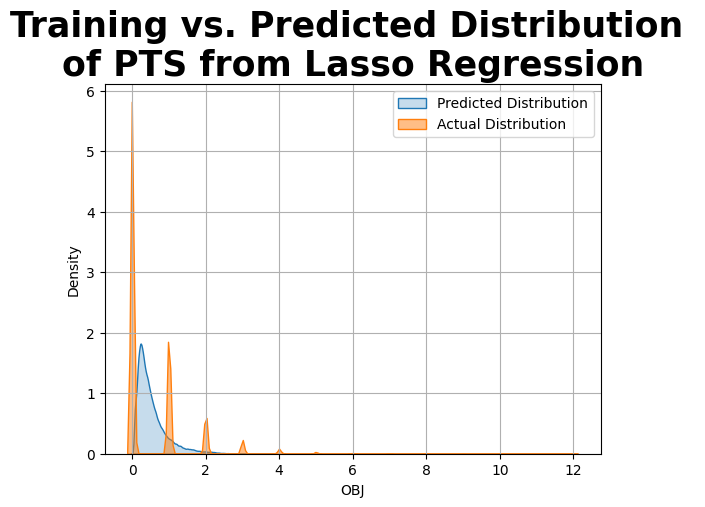

In [104]:
bins = np.linspace(0, 2, 30)
sns.kdeplot(Yhat_train, fill=True,bw_adjust = 0.5, label = "Predicted Distribution")
sns.kdeplot(Ytrain, fill=True, bw_adjust = 0.5, alpha=0.5, label = "Actual Distribution")
plt.title("Training vs. Predicted Distribution \nof PTS from Lasso Regression", fontweight="bold", fontsize=25)
plt.legend()
plt.grid()

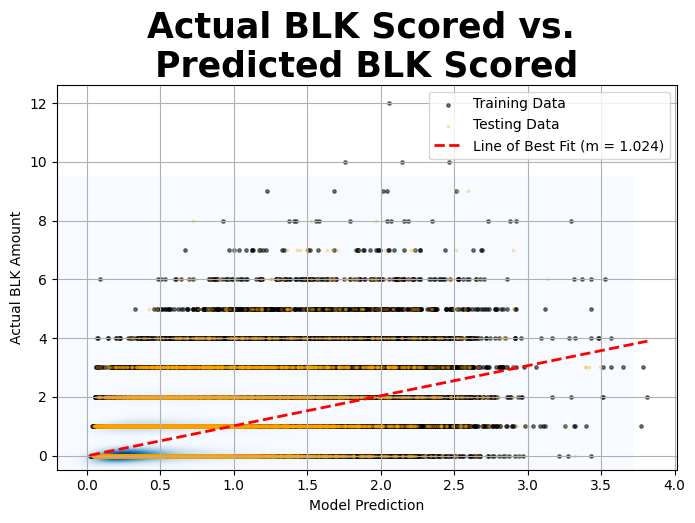

In [105]:
import matplotlib.pyplot as plt 
from sklearn.linear_model import LinearRegression, Lasso

lr = LinearRegression()
lr.fit(model.predict(Xtrain).reshape(-1,1), Ytrain)
x = np.array([min(Yhat_train), max(Yhat_train)])
y = lr.predict(x.reshape(-1,1))

data = np.hstack((Yhat_test.reshape(-1,1), Ytest.to_numpy().reshape(-1,1)))
df = pd.DataFrame(data, columns=['X', 'Y'])


plt.figure(figsize=(8,5))
sns.kdeplot(data=df, x="X", y="Y", fill=True, thresh=0, levels=100, cmap="Blues", bw_adjust=1.0)
plt.scatter(Yhat_train, Ytrain, s=6.0, label = "Training Data", c='black', alpha=0.5)
plt.scatter(Yhat_test, Ytest, s=3.0, label = "Testing Data", c='orange', alpha=0.25)
plt.plot(x,y, color='red', linestyle='--', linewidth=2, label='Line of Best Fit (m = %.3f)' % (lr.coef_[0]))
plt.title("Actual " + stat_of_interest + " Scored vs. \nPredicted "+stat_of_interest+" Scored", fontweight="bold", fontsize=25)
plt.grid()
plt.xlabel("Model Prediction")
plt.ylabel("Actual " + stat_of_interest + " Amount")
#plt.xlim([0, np.max(Ytrain)])
plt.legend()

In [49]:
new_model = Lasso(9e-2)
new_model.fit(X, Y)

Yhat = new_model.predict(X)

In [72]:
def get_line_prob(Yhat, Y, line, model_pred, over = True, max_score=80, show_hist = True):
    # Filter out the observations that fall within a specific period 
    Y_spec = Y[np.round(Yhat) == np.round(model_pred)]
    # create historgram 
    bins = np.linspace(-0.5, max_score+0.5, max_score+2)    
    plt.figure(figsize=(10,8))
    (freqs, pts, _) = plt.hist(Y_spec, bins = bins, color='skyblue', edgecolor='black', alpha=0.7)
    
    # Compute probability 
    tot_obs = np.sum(freqs)
    P = freqs / tot_obs 
    over_prob = np.sum(P[(pts[:-1]+0.5) > line])
    if over:
        return over_prob
    else:
        return 1 - over_prob

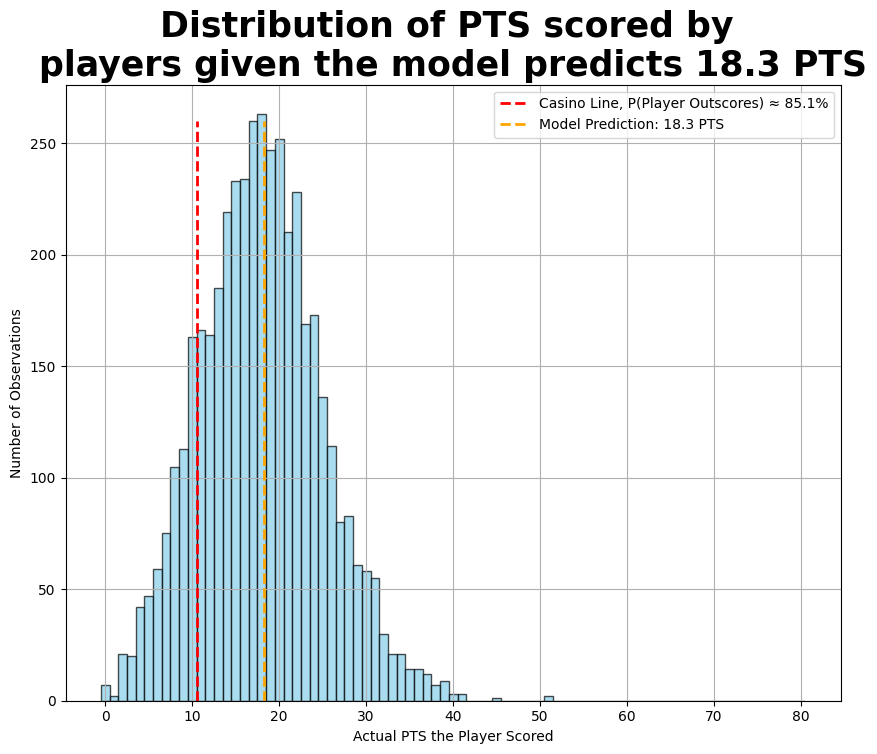

In [75]:
prob = get_line_prob(Yhat, Y, 10.5, 18.3)
plt.plot([10.5, 10.5], [0, 260], color='red', linestyle='--', linewidth=2, label = "Casino Line, P(Player Outscores) ≈ %.1f%%" % (100*prob))
plt.plot([18.3, 18.3], [0, 260], color='orange', linestyle='--', linewidth = 2, label = "Model Prediction: %.1f PTS" % (18.3))
plt.ylabel("Number of Observations")
plt.xlabel("Actual PTS the Player Scored")
plt.legend()
plt.title("Distribution of PTS scored by \nplayers given the model predicts 18.3 PTS", fontweight = "bold",fontsize=25)
plt.grid()